## Load Library and Dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Set Kaggle API
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Get dataset from kaggle
!kaggle datasets download -d saadhaxxan/germantrafficsigns

 96% 113M/118M [00:03<00:00, 33.4MB/s]
100% 118M/118M [00:03<00:00, 32.3MB/s]


In [ ]:
# Extract File
with ZipFile("/content/germantrafficsigns.zip", "r") as zip_ref:
  zip_ref.extractall('working')

In [ ]:
# Load Data
training_file = '/content/working/train.p'
testing_file = '/content/working/test.p'

# Membuka dan load data training file
with open(training_file, mode='rb') as f:
  train = pickle.load(f)

# Membuka dan load data testing file
with open(testing_file, mode='rb') as f:
  test = pickle.load(f)


print('Data Loaded')

Data Loaded


In [ ]:
df_sign = pd.read_csv('/content/working/signnames.csv')
SIGN_NAMES = df_sign.SignName.values
df_sign.set_index('ClassId', inplace = True)
df_sign.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [ ]:
# Define features and labels for training data
X, y = train['features'], train['labels']

# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Define features and labels for testing data
X_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [ ]:
# Membagi data train menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 1310)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


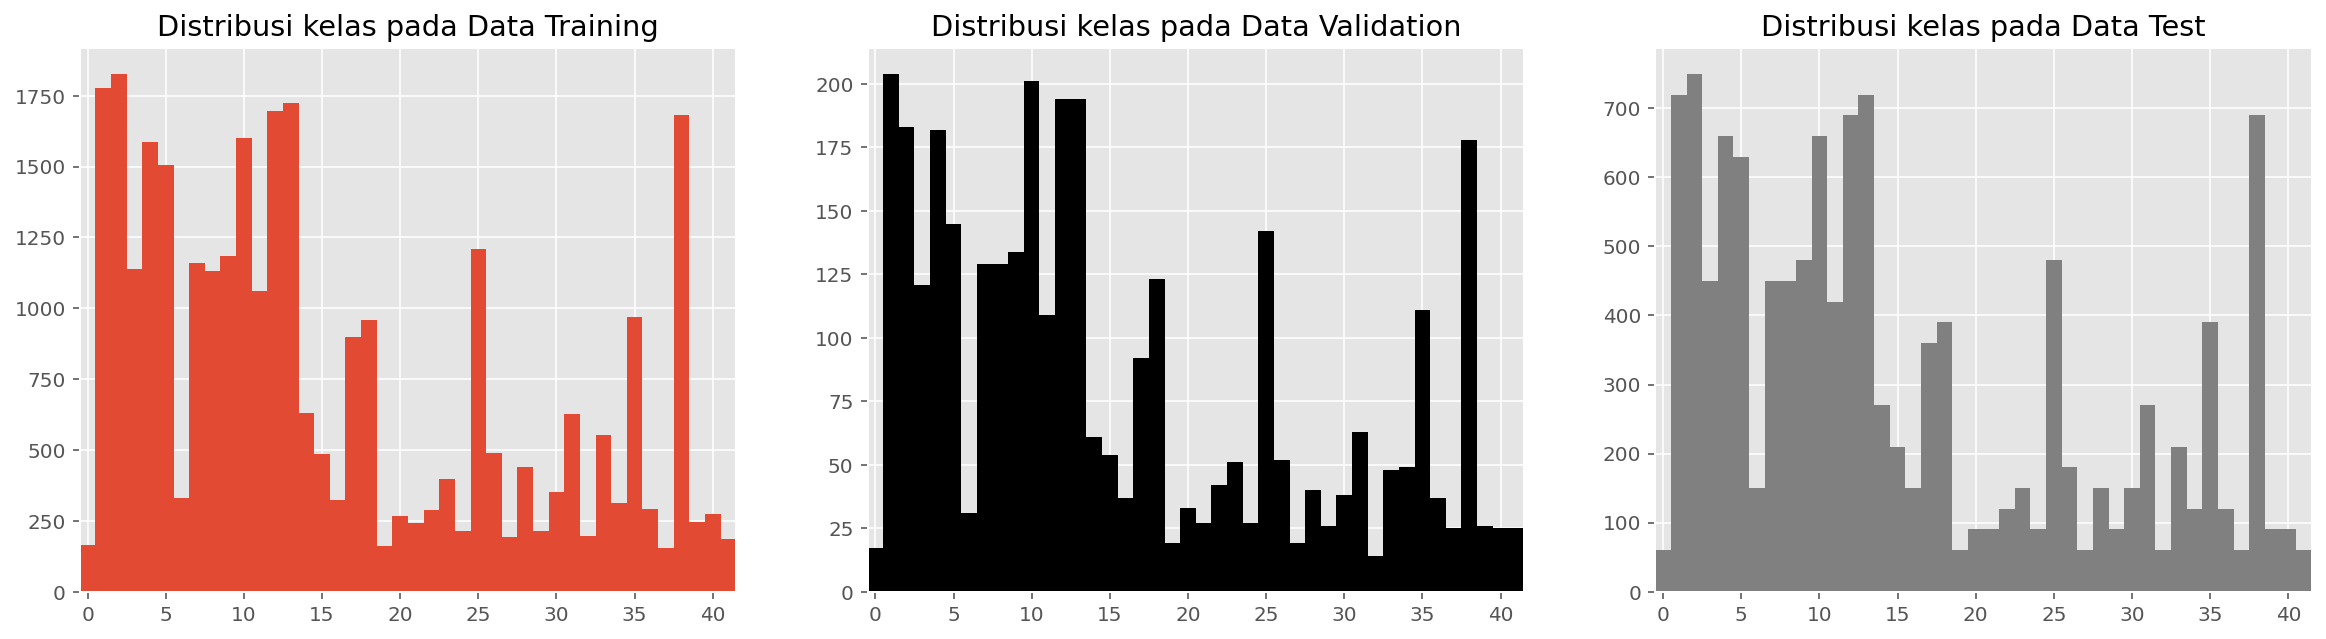

In [ ]:
# Visualisasi distribusi data
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
  if not ax:
    fig = plt.figure()
    ax = fig.add_subplot(111)
  ax.hist(y_data, np.arange(-0.5, n_labels+1.5  ), stacked=True, **kwargs)
  ax.set_xlim(-0.5, n_labels-1.5)
  if 'label' in kwargs : ax.legend()
  if title : ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize = (20,5))
hist_data(y_train, title = 'Distribusi kelas pada Data Training', ax = ax[0])
hist_data(y_val, title = 'Distribusi kelas pada Data Validation', ax = ax[1], color = 'black')
hist_data(y_test, title = 'Distribusi kelas pada Data Test', ax = ax[2], color = 'grey')

Dari plot yang tertampil, dapat dilihat bahwa distribusi kelas masing-masing bagian data terlihat mirip. Oleh karena itu, kita tidak perlu melakukan proses normalisasi. 

In [ ]:
# Converting the labels into one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
# Membuat callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai > 96%. Stop Training!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# Membuat model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Fit the model
hist = model.fit(X_train, y_train,
                 batch_size = 32,
                 epochs = 25,
                 validation_data=(X_val, y_val),
                 callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 135s 137ms/step - loss: 1.8623 - accuracy: 0.5194 - val_loss: 0.4493 - val_accuracy: 0.8842
Epoch 2/25
979/979 [==============================] - 134s 137ms/step - loss: 0.6786 - accuracy: 0.7977 - val_loss: 0.2367 - val_accuracy: 0.9322
Epoch 3/25
979/979 [==============================] - 134s 137ms/step - loss: 0.4528 - accuracy: 0.8613 - val_loss: 0.1734 - val_accuracy: 0.9503
Epoch 4/25
979/979 [==============================] - 134s 137ms/step - loss: 0.3794 - accuracy: 0.8877 - val_loss: 0.1375 - val_accuracy: 0.9598
Epoch 5/25
979/979 [==============================] - 134s 137ms/step - loss: 0.3235 - accuracy: 0.9026 - val_loss: 0.0961 - val_accuracy: 0.9704
Epoch 6/25
979/979 [==============================] - 134s 137ms/step - loss: 0.2967 - accuracy: 0.9131 - val_loss: 0.0942 - val_accuracy: 0.9724
Epoch 7/25
979/979 [==============================] - 134s 137ms/step - loss: 0.2569 - accuracy: 0.9238 - val_loss: 0.1056 -

In [ ]:
# Save model
model.save('trafficsign.h5')

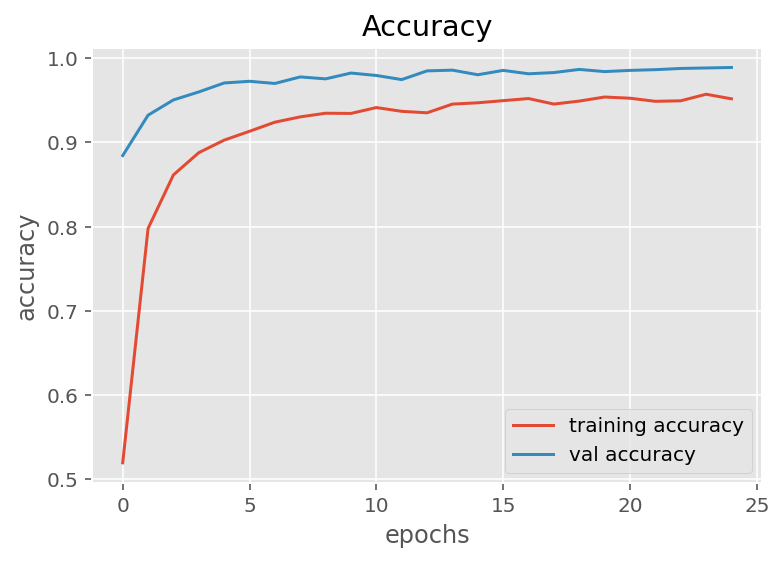

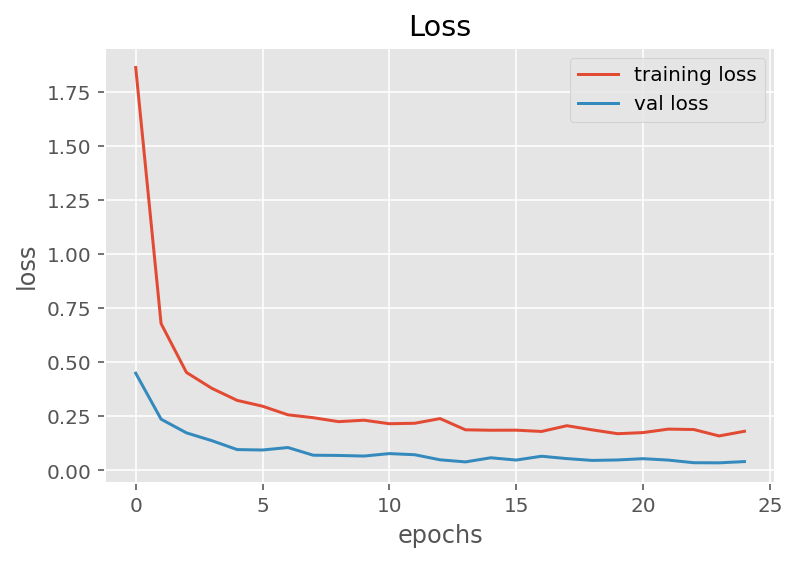

In [ ]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Testing accuracy with test data
from sklearn.metrics import accuracy_score

y_pred = np.argmax(model.predict(X_test,), axis=-1)
accuracy_score(y_test, y_pred)

0.9475851148060174

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.95      0.98      0.96       720
           2       0.96      0.98      0.97       750
           3       0.91      0.94      0.92       450
           4       0.97      0.96      0.96       660
           5       0.90      0.92      0.91       630
           6       1.00      0.79      0.88       150
           7       0.96      0.96      0.96       450
           8       0.94      0.94      0.94       450
           9       0.97      0.99      0.98       480
          10       0.94      0.99      0.96       660
          11       0.88      0.97      0.93       420
          12       0.98      0.98      0.98       690
          13       0.99      0.98      0.99       720
          14       0.98      0.99      0.99       270
          15       0.92      1.00      0.96       210
          16       0.99      0.99      0.99       150
          17       0.99    